In [ ]:
pip install torch torchvision matplotlib

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [33]:
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

In [ ]:
train_data = datasets.MNIST(root= 'data', train=True, transform= ToTensor(), download=True)
test_data = datasets.MNIST(root= 'data', train=False, transform= ToTensor(), download=True)  # Testing data therefore training is set to False

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 17117172.19it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 483006.81it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4367719.92it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2898300.44it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
train_data  # 60,000 datapoints

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
test_data  # note that this only has 10,000 datapoints

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [ ]:
train_data.targets  # the individual class ie numbers from 0 to 9

tensor([5, 0, 4,  ..., 5, 6, 8])

In [ ]:
loaders = {
    'train': DataLoader(
        train_data,
        batch_size=100,
        shuffle=True,
        num_workers=1
    ),
    'test': DataLoader(
        test_data,
        batch_size=100,
        shuffle=True,
        num_workers=1
    )
}

In [ ]:
print(loaders)

{'train': <torch.utils.data.dataloader.DataLoader object at 0x7895f4c01210>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7895f4c011e0>}


In [ ]:
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7895f4c01210>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7895f4c011e0>}

In [19]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [28]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()

    self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    self.conv2_drop = nn.Dropout2d()
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, 10)

  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
    x = x.view(-1, 320)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, training=self.training)
    x = self.fc2(x)

    return F.softmax(x)

#  Here you have the full architecture of the CNN -- we still need to train and test it

In [29]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model= CNN().to(device)  # moving everything to the device if we do have a cude gpu available

optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_fn = nn.CrossEntropyLoss()

def train(epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(loaders['train']):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = loss_fn(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 20 == 0:
      print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(loaders["train"].dataset)} ({100. * batch_idx / len(loaders["train"]):.0f}%)]\t{loss.item():.6f}')


def test():  # test therefore no epochs paramater
  model.eval()

  test_loss = 0
  correct = 0

  with torch.no_grad():
    for data, target in loaders["test"]:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += loss_fn(output, target).item()
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(loaders["test"].dataset)
  print(f'\nTest set: Average loss: {test_loss: 4f}, Accuracy {correct}/{len(loaders["test"].dataset)} ({100. * correct / len(loaders["test"].dataset):.0f}%\n)')



In [32]:
# we can start the training now

for epoch in range(1, 11):
  train(epoch)
  test()  # 98% accuracy which is great!

<ipython-input-28-0a9cb36f43b8>:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Train Epoch: 1 [0/60000 (0%)]	1.508449
Train Epoch: 1 [2000/60000 (3%)]	1.518146
Train Epoch: 1 [4000/60000 (7%)]	1.494835
Train Epoch: 1 [6000/60000 (10%)]	1.535080
Train Epoch: 1 [8000/60000 (13%)]	1.539660
Train Epoch: 1 [10000/60000 (17%)]	1.508091
Train Epoch: 1 [12000/60000 (20%)]	1.511023
Train Epoch: 1 [14000/60000 (23%)]	1.519872
Train Epoch: 1 [16000/60000 (27%)]	1.538100
Train Epoch: 1 [18000/60000 (30%)]	1.504233
Train Epoch: 1 [20000/60000 (33%)]	1.546545
Train Epoch: 1 [22000/60000 (37%)]	1.556035
Train Epoch: 1 [24000/60000 (40%)]	1.589998
Train Epoch: 1 [26000/60000 (43%)]	1.512392
Train Epoch: 1 [28000/60000 (47%)]	1.501809
Train Epoch: 1 [30000/60000 (50%)]	1.504684
Train Epoch: 1 [32000/60000 (53%)]	1.574888
Train Epoch: 1 [34000/60000 (57%)]	1.561221
Train Epoch: 1 [36000/60000 (60%)]	1.532894
Train Epoch: 1 [38000/60000 (63%)]	1.547708
Train Epoch: 1 [40000/60000 (67%)]	1.537821
Train Epoch: 1 [42000/60000 (70%)]	1.574266
Train Epoch: 1 [44000/60000 (73%)]	1.514768

<ipython-input-28-0a9cb36f43b8>:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Prediction: 1


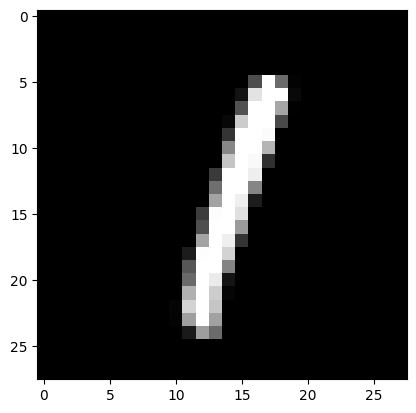

In [40]:
model.eval()
data, target = test_data[5]
data = data.unsqueeze(0).to(device)
output = model(data)
prediction = output.argmax(dim=1, keepdim=True).item()
print(f"Prediction: {prediction}")

image = data.squeeze(0).squeeze(0).cpu().numpy()

plt.imshow(image, cmap='gray')
plt.show()

# There we go! We predicted that it will be number 1 and we were correct!